# **Face Mask Detector**

# I- Importing data from Kaggle:

In [3]:
! pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"idrissbenhmida","key":"b9921c14a1988686bae49ff6c0bd992a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

# II- Data Understanfing:

In [6]:
import os
import tensorflow as tf
import datetime
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import shutil
%load_ext tensorboard

path = "Face Mask Dataset/"

In [7]:
print("Images in Train Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Train/WithMask"))))
print("Number of Images for with WithoutMask category:{} \n".format(len(os.listdir(path+"Train/WithoutMask/"))))

print("Images in Validation Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Validation/WithMask"))))
print("Number of Images for with WithoutMask category:{} \n".format(len(os.listdir(path+"Validation/WithoutMask/"))))

print("Images in Test Dataset:")
print("Number of Images for with Mask category:{}".format(len(os.listdir(path+"Test/WithMask"))))
print("Number of Images for with WithoutMask category:{}".format(len(os.listdir(path+"Test/WithoutMask/"))))

Images in Train Dataset:
Number of Images for with Mask category:5000
Number of Images for with WithoutMask category:5000 

Images in Validation Dataset:
Number of Images for with Mask category:400
Number of Images for with WithoutMask category:400 

Images in Test Dataset:
Number of Images for with Mask category:483
Number of Images for with WithoutMask category:509


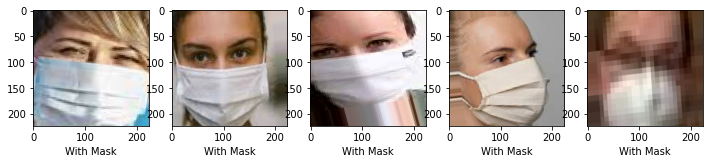

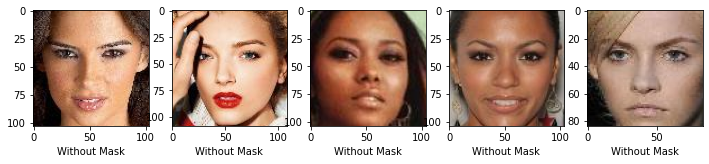

In [8]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(path+"Train/WithMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(path+"Train/WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(path+"Train/WithoutMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(path+"Train/WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

# III- Data Preparation:

### Data Augmentation:

In [22]:
height = 150
width=150
train_dir = path + 'Train'
val_dir = path + 'Validation'
test = path + 'Test'


train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=val_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

test = train_datagen.flow_from_directory(directory=test_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32)

Found 8000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# IV- Modeling:

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150,150,3))

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
for layer in mobilenet.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [16]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#%tensorboard --logdir logs/fit

In [17]:
history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,validation_data=valid,
                             validation_steps = len(valid)//32,callbacks=[tensorboard_callback],epochs=15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
7/7 [==============================] - 10s 1s/step - loss: 0.8146 - accuracy: 0.7452 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 2/15
7/7 [==============================] - 6s 831ms/step - loss: 0.5150 - accuracy: 0.9694 - val_loss: 0.1288 - val_accuracy: 0.9688
Epoch 3/15
7/7 [==============================] - 6s 807ms/step - loss: 0.0393 - accuracy: 0.9929 - val_loss: 0.6504 - val_accuracy: 0.9375
Epoch 4/15
7/7 [==============================] - 6s 844ms/step - loss: 0.1223 - accuracy: 0.9666 - val_loss: 1.0593e-05 - val_accuracy: 1.0000
Epoch 5/15
7/7 [==============================] - 6s 818ms/step - loss: 0.0600 - accuracy: 0.9847 - val_loss: 0.5958 - val_accuracy: 0.9062
Epoch 6/15
7/7 [==============================] - 6s 811ms/step - loss: 0.4172 - accuracy: 0.9622 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 6s 807ms/step - loss: 0.0955 - accuracy: 0.9879 - val_loss: 3.7253e-09 - val_accuracy: 1.0000
Epoch 8/15

# V- Evaluation:

In [23]:
model.evaluate(test, verbose=0)

[0.03666521608829498, 0.9925000071525574]

In [18]:
model.save("face_mask.h5")